# DATA ANALYSIS

In [1]:
## download data

# import requests

# url = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Video_Games.json.gz"
# filename = url.split("/")[-1]
# with open(filename, "wb") as f:
#     r = requests.get(url)
#     f.write(r.content)

In [2]:
import gzip
import json
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [5]:
data = parse("./data/Video_Games.json.gz")

In [6]:
import random
data = list(data)
random.seed(0)
random.shuffle(data)
print(len(data))

2565349


In [7]:
traindata = data[:50000]
validdata = data[50000:75000]
testdata = data[75000:100000]

In [8]:
traindata[0]

{'overall': 2.0,
 'verified': True,
 'reviewTime': '11 30, 2017',
 'reviewerID': 'A2HCWBUZ5EV1ZE',
 'asin': 'B01F3Y79TW',
 'style': {'Color:': ' SA920 White Black'},
 'reviewerName': 'Cion',
 'reviewText': 'Really Bad, I bought this for my ps4 and to my surprise the sound quality is horrible. The earbuds at my local convenience store sound better and those were only 6$ Idk if this is how they are supposed to sound (i can barely listen to the games in my ps4 with max volume) or if mine just came defective.',
 'summary': 'Maximum sound level is too low.',
 'unixReviewTime': 1512000000}

In [9]:
traindata[1].keys()

dict_keys(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime'])

In [10]:
from collections import defaultdict
userset = set()
itemset = set()
averageRating = 0
ratingCount = defaultdict(int)
acc = 0
counter = 0


for d in traindata:
    userset.add(d['reviewerID'])
    itemset.add(d['asin'])
    acc += float(d['overall'])
    counter+=1
    ratingCount[d['overall']] += 1
averageRating = acc/counter

# basic analysis

In [11]:
print("Number of user: %d \nNumber of items: %d \naverageRating = %f"%(len(userset),len(itemset),averageRating)) 


Number of user: 48218 
Number of items: 16602 
averageRating = 4.034360


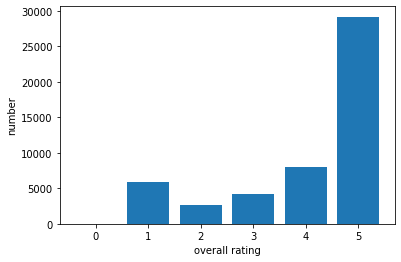

In [12]:
import matplotlib.pyplot as plt
x = range(6)
y = [ ratingCount[xx] for xx in x]
plt.bar(x,y)
plt.ylabel('number')
plt.xlabel('overall rating')
plt.show()

## avr rating is high

In [13]:
lenAndRating = []
noReviewCount = 0
noSumCount = 0
commonCount = 0
for index,d in enumerate(traindata) :

    if('reviewText' not in d.keys()):
        noReviewCount+=1
        continue
    if('summary' not in d.keys()):
        noSumCount+=1
        continue
    lenAndRating.append(        (     len(d['reviewText'].replace('\n','').replace('\'','')),  len(d['summary']),   d['overall']      )                )
    commonCount+=1


print("normal data:%d \ndata without reviewtext:%d\ndata without summary:%d"%(commonCount,noReviewCount,noSumCount))

    

normal data:49961 
data without reviewtext:30
data without summary:9


## Tiny part data are not complete, just use average to predict rating

In [14]:
lenAndRating.sort(key=lambda s:-s[0])

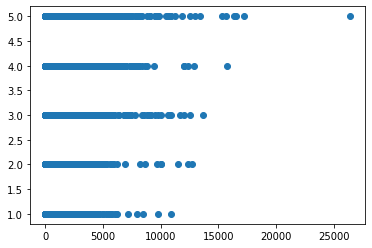

In [15]:
x = [i[0] for i in lenAndRating]
y = [i[2] for i in lenAndRating]

plt.scatter(x,y)
plt.show()

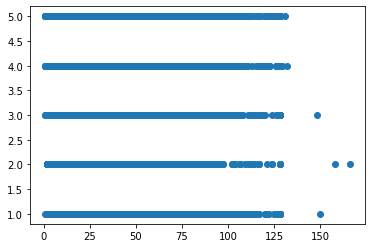

In [16]:
x = [i[1] for i in lenAndRating]
y = [i[2] for i in lenAndRating]

plt.scatter(x,y)
plt.show()

## length of the text and summary only give small info

In [17]:
from transformers import pipeline


In [18]:
senti = pipeline('sentiment-analysis',device=-1)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [19]:
sentiAndRating = []
for index,d in enumerate(traindata[:1000]) :
    # print('process : %s'%(str(index/len(traindata)*100)+'%'),end='\r')
    if('reviewText' not in d.keys()):
        continue
    if('summary' not in d.keys()):
        continue
    sentiAndRating.append(        (     senti(d['reviewText'].replace('\n','').replace('\'','')[:500]),   d['overall']     ,d['reviewText'] )                )
    # commonCount+=1


In [20]:
sentiAndRating[:2]

[([{'label': 'NEGATIVE', 'score': 0.9997990727424622}],
  2.0,
  'Really Bad, I bought this for my ps4 and to my surprise the sound quality is horrible. The earbuds at my local convenience store sound better and those were only 6$ Idk if this is how they are supposed to sound (i can barely listen to the games in my ps4 with max volume) or if mine just came defective.'),
 ([{'label': 'POSITIVE', 'score': 0.9555410742759705}],
  5.0,
  'I\'ve been a PS fan for a very long time but decided to get a Nintendo Wii U. for myself this time around. Just when I got my console This particular donkey Kong tropical freeze was one of the first game i got for myself. this game is so interesting and the graphics are so beautiful. I don\'t regret spending $49 for this game. It is a grate game. The only draw back is some tasks are really hard and the number of chances per session are too small. just 2 hearts. They should have made it such that, you get as many chances as you can depending on the number 

In [21]:
wrongCount = 0##strong false case
for x in sentiAndRating:
    # print(x[0])
    if(x[0][0]['label']=='NEGATIVE' and int(x[1])>=5):
        wrongCount += 1
print(wrongCount/len(sentiAndRating))

0.06006006006006006


## seems highly related to the sentiment of the review text

In [22]:
sentiAndRating = []
for index,d in enumerate(traindata[:1000]) :
    # print('process : %s'%(str(index/len(traindata)*100)+'%'),end='\r')
    if('reviewText' not in d.keys()):
        continue
    if('summary' not in d.keys()):
        continue
    sentiAndRating.append(        (     senti(d['summary'].replace('\n','').replace('\'','')[:500]),   d['overall']      )                )
    # commonCount+=1


In [23]:
sentiAndRating[:40]

[([{'label': 'NEGATIVE', 'score': 0.9997206330299377}], 2.0),
 ([{'label': 'POSITIVE', 'score': 0.9998500347137451}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9996333122253418}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9990085959434509}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9998682737350464}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9990085959434509}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9978646636009216}], 4.0),
 ([{'label': 'POSITIVE', 'score': 0.9542957544326782}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9998681545257568}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9998236298561096}], 4.0),
 ([{'label': 'POSITIVE', 'score': 0.9980767965316772}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9998300075531006}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9925018548965454}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9901392459869385}], 4.0),
 ([{'label': 'POSITIVE', 'score': 0.997701108455658}], 5.0),
 ([{'label': 'POSITIVE', 'score': 0.9622761607170105}], 2.0),
 ([{'labe

## summary's sentiment works worse than origin text's

## to do: normalize the score, use it  as a feature, to train a regression model

# PREPROCESSING

In [24]:
import numpy as np

import torch 

In [25]:
senti = pipeline('sentiment-analysis',device=0,model="distilbert-base-uncased-finetuned-sst-2-english")

In [26]:
senti(d['reviewText'].replace('\n','').replace('\'','')[:500])

[{'label': 'NEGATIVE', 'score': 0.9973504543304443}]

In [27]:
my_dataset = []
count = 0

for index,d in enumerate(traindata) :
    if(count>=100000):break
    count+=1


    # print('process : %s'%(str(index/len(traindata)*100)+'%'),end='\r')
    if('reviewText' not in d.keys()):
        continue

    output = senti(d['reviewText'].replace('\n','').replace('\'','')[:500])[0]
    output = -1* float(output['score']) if output['label']=='NEGATIVE' else float(output['score'])
    my_dataset.append(   [len(d['reviewText'])   ,   output ,d['reviewerID'],d['asin'] ,d['overall']   ]  )
    # commonCount+=1
my_dataset = np.save('.data/my_dataset.npy')

C:\Users\kevin\miniconda3\envs\python38\lib\site-packages\transformers\pipelines\base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


KeyboardInterrupt: 

In [29]:

my_dataset = np.load('./data/my_dataset.npy')

In [30]:
my_dataset

array([['303', '-0.9997990727424622', 'A2HCWBUZ5EV1ZE', 'B01F3Y79TW',
        '2.0'],
       ['804', '0.9555448889732361', 'A2MUNUJDYLW0QN', 'B00DC7O77A',
        '5.0'],
       ['52', '0.9997385144233704', 'AD292QEGUWM9N', 'B01E17LW2W', '5.0'],
       ...,
       ['205', '-0.9994385838508606', 'A16HT9CNFW091H', 'B002I096Q4',
        '1.0'],
       ['427', '0.9997395873069763', 'A2I6LBBBQN9JXK', 'B0002Y2XXQ',
        '5.0'],
       ['768', '0.9996108412742615', 'A7O07YZ4WKVU8', 'B00JF63SQI',
        '5.0']], dtype='<U32')

In [31]:
my_dataset.shape

(100000, 5)

In [32]:
my_train = my_dataset[:50000]
my_valid = my_dataset[50000:75000]
my_test = my_dataset[75000:]

In [33]:
len(my_test)

25000

In [34]:

def norm(x,minn,maxx):
    return (x-minn)/(maxx-minn)
def preprocess(dataset):
    score = []
    length = []
    for data in dataset:
        score.append(abs(float(data[1])))
        length.append(float(data[0]))
    
    ret = []
    minn_score = min(score)
    maxx_score = max(score)
    minn_len = min(length)
    maxx_len = max(length)
    for dd in dataset:
        d = float(dd[1])
        ret.append( [norm(float(dd[0]),minn_len,maxx_len), (-1 if d<=0 else 1) * norm(abs(d),minn_score,maxx_score),dd[2],dd[3],float(dd[4])])
    return ret

In [35]:
preprocessed_my_train = preprocess(my_train)



In [36]:
users = set()
items = set()
for d in preprocessed_my_train:
    users.add(d[2])
    items.add(d[3])
userlist = (list(users))
itemlist = (list(items))

In [37]:
from collections import defaultdict
itemIDs = defaultdict(int)
userIDs = defaultdict(int)
USERLEN = len(userlist)
ITEMLEN = len(itemlist)
for d in preprocessed_my_train:
    userIDs[d[2]] = len(userIDs)
    itemIDs[d[3]] = len(itemIDs)

In [38]:
'A22DB8ICVH0PTE' in userIDs.keys()

False

In [39]:
import torch
from torch.autograd import Variable
import torch.nn as nn
class LatentFactor(nn.Module):
 
    def __init__(self, mu, K=3,lamb = 0.0001):
        super(LatentFactor, self).__init__()
        self.lamb = lamb
        
        self.alpha = mu
        # self.gammaU = nn.Parameter(torch.normal(mean=torch.ones( len(userIDs),K)*1e-5,std=torch.ones(len(userIDs),1)*0.001),requires_grad=True)
        # self.gammaI = nn.Parameter(torch.normal(mean=torch.ones( len(recipeIDs),K)*1e-5,std=torch.ones(len(recipeIDs),1)*0.001),requires_grad=True)
        self.betaU = nn.Parameter(torch.normal(mean=torch.ones(1, USERLEN),std=torch.ones(USERLEN)*0.001),requires_grad=True)
        self.betaI = nn.Parameter(torch.normal(mean=torch.ones(1, ITEMLEN),std=torch.ones(ITEMLEN)*0.001),requires_grad=True)
        self.thetaI = nn.Parameter(torch.normal(mean=torch.ones(3),std=torch.ones(3)*0.001),requires_grad=True)


    def forward(self,u,i,x):
        u =u.cuda()
        i=i.cuda()
        x=x.cuda()
        # print(u)
        # print(self.betaU)
        # print(self.thetaI.shape,x.shape)
        a = torch.index_select(self.betaU[0],0,u)
        b = torch.index_select(self.betaI[0],0,i)
        c = torch.matmul(x.view(-1,3),self.thetaI.view(3,-1))
        # print(a.shape,b.shape,c.shape)
        return c.squeeze(-1)
    def reg(self):
        # print(torch.sum(self.betaI**2))
        return self.lamb * (torch.sum(self.betaU**2) +\
                            torch.sum(self.betaI**2) +\
                            torch.sum(self.thetaI**2))



In [40]:
model = LatentFactor(0)


In [41]:
input = preprocessed_my_train[0]

In [42]:
input

[0.011322310951149103,
 -0.9998092014537918,
 'A2HCWBUZ5EV1ZE',
 'B01F3Y79TW',
 2.0]

In [43]:
preprocessed_my_train = [[d[0],d[1],userIDs[d[2]] ,itemIDs[d[3]] ,d[4]] for d in preprocessed_my_train]

In [44]:
x = [d[:2] for d in preprocessed_my_train]
for i in range(len(x)):
    x[i].append(1.0)

x=np.array(x,dtype=float)
# x = x.transpose()
x=torch.FloatTensor(x)
u = [d[2] for d in preprocessed_my_train]
u=np.array(u)
u=torch.IntTensor(u)
i = [d[3] for d in preprocessed_my_train]
i=np.array(i)
i=torch.IntTensor(i)
y = [d[-1] for d in preprocessed_my_train]
y=np.array(y)
y=torch.FloatTensor(y).cuda()


In [45]:
x

tensor([[ 0.0113, -0.9998,  1.0000],
        [ 0.0301,  0.9112,  1.0000],
        [ 0.0019,  0.9997,  1.0000],
        ...,
        [ 0.0015,  0.9997,  1.0000],
        [ 0.0556,  0.9984,  1.0000],
        [ 0.0037,  0.9752,  1.0000]])

In [46]:
loss_func = torch.nn.MSELoss()
model =model.cuda()
def step(optimizer):
        
    pre = model(u,i,x)
    # print(torch.Tensor(sampleR))
    # print(pre)                         
    loss = loss_func(y,pre)
    # print(y,pre)
    
    # print(loss)
    loss += model.reg()
    optimizer.zero_grad()
    loss.backward()  
    optimizer.step()
    return loss.item()



In [47]:

optimizer1 = torch.optim.Adam(model.parameters(), lr=0.01)
for s in range(10000):
    print(step(optimizer1))
    

14.76889419555664
14.568010330200195
14.369861602783203
14.168327331542969
13.97393798828125
13.781448364257812
13.589216232299805
13.400531768798828
13.208841323852539
13.024185180664062
12.841516494750977
12.66085147857666
12.482131958007812
12.300609588623047
12.126057624816895
11.953558921813965
11.783119201660156
11.614748001098633
11.44845199584961
11.28416633605957
11.123353958129883
10.963287353515625
10.806581497192383
10.65066909790039
10.498074531555176
10.346317291259766
10.19782543182373
10.051370620727539
9.90694522857666
9.76350212097168
9.623146057128906
9.485870361328125
9.349509239196777
9.2195405960083
9.087135314941406
8.957685470581055
8.829261779785156
8.707962989807129
8.583320617675781
8.461562156677246
8.34583854675293
8.227720260620117
8.115687370300293
8.001213073730469
7.893479824066162
7.78262996673584
7.677587032318115
7.570991039276123
7.470085144042969
7.366863250732422
7.268570899963379
7.172646522521973
7.075005531311035
6.982193946838379
6.89099788665

In [48]:
preprocessed_my_test = preprocess(my_test)
preprocessed_my_test = [[d[0],d[1],userIDs[d[2]] ,itemIDs[d[3]] ,d[4]] for d in preprocessed_my_test]

In [49]:
my_test

array([['220', '0.9929234981536865', 'A22DB8ICVH0PTE', 'B00E4MQODC',
        '5.0'],
       ['94', '-0.996970534324646', 'AMJN68XPAC17X', 'B00NGIYFOA', '1.0'],
       ['1183', '-0.9941619038581848', 'A3RPTSGDDOKHV', 'B000YDIA78',
        '1.0'],
       ...,
       ['205', '-0.9994385838508606', 'A16HT9CNFW091H', 'B002I096Q4',
        '1.0'],
       ['427', '0.9997395873069763', 'A2I6LBBBQN9JXK', 'B0002Y2XXQ',
        '5.0'],
       ['768', '0.9996108412742615', 'A7O07YZ4WKVU8', 'B00JF63SQI',
        '5.0']], dtype='<U32')

In [50]:
userIDs['A2CO6QZ310VJLI']

48214

In [51]:
x = [d[:2] for d in preprocessed_my_test]
for i in range(len(x)):
    x[i].append(1.0)

x=np.array(x,dtype=float)
# x = x.transpose()
x=torch.FloatTensor(x)
u = [d[2] for d in preprocessed_my_test]
u=np.array(u)
u=torch.IntTensor(u)
i = [d[3] for d in preprocessed_my_test]
i=np.array(i)
i=torch.IntTensor(i)
y = [d[-1] for d in preprocessed_my_test]
y=np.array(y)
y=torch.FloatTensor(y).cuda()

In [52]:
x

tensor([[ 0.0118,  0.9860,  1.0000],
        [ 0.0050, -0.9941,  1.0000],
        [ 0.0638, -0.9885,  1.0000],
        ...,
        [ 0.0110, -0.9991,  1.0000],
        [ 0.0230,  0.9997,  1.0000],
        [ 0.0414,  0.9994,  1.0000]])

In [53]:
pre = model(u,i,x)                 
loss = loss_func(y,pre)
print(loss)
for a,b in zip(y,pre):
    print(a.data,b.data)

tensor(1.0835, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5., device='cuda:0') tensor(4.7091, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.6628, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.6741, device='cuda:0')
tensor(5., device='cuda:0') tensor(4.7232, device='cuda:0')
tensor(5., device='cuda:0') tensor(4.7227, device='cuda:0')
tensor(5., device='cuda:0') tensor(2.6931, device='cuda:0')
tensor(4., device='cuda:0') tensor(4.7228, device='cuda:0')
tensor(5., device='cuda:0') tensor(4.4998, device='cuda:0')
tensor(5., device='cuda:0') tensor(4.7181, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.6605, device='cuda:0')
tensor(5., device='cuda:0') tensor(4.7241, device='cuda:0')
tensor(4., device='cuda:0') tensor(4.7233, device='cuda:0')
tensor(4., device='cuda:0') tensor(2.6709, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.6575, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.6569, device='cuda:0')
tensor(2., device='cuda:0') tensor(2.656